#CLASIFICACIÓN TEXTUAL

**Autores**

>Brian Nicolas G. Sosa

>Andrés Felipe Villa Escobar

### Referencias

1. Latent Dirichlet Allocation, Blei D., 2003:http://www.jmlr.org/papers/volume3/blei03a/blei03a.pd
2. Full-Text or Abstract? Examining Topic Coherence Scores Using Latent Dirichlet Allocation, Syed S., 2017: saf21.eu/wp-content/uploads/2017/09/5004a165.pdf
3. Intuitive Guide to Latent Dirichlet Allocation, Ganegedara T., 2013: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158
4. LDA on texts of Harry Potter, Rafferty G.,2018:
https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5#:~:text=The%20difference%20between%20Mallet%20and,Latent%20Dirichlet%20Allocation%20via%20Mallet.
5. Topic Modeling with Gensim (Python), Prabhakaran S., 2018: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#13viewthetopicsinldamodel 
6. Curso ciencia de datos, Montenegro A. 2020: https://github.com/AprendizajeProfundo/Ciencia-de-Datos 

###Introducción

En el presente documento se utilizaran métodos de aprendizaje automático como el Latent Dirichlet Allocation (LDA) para la clasificación de textos.

### Modelo LDA

En primer lugar se deben tener en cuenta las siguientes definiciones: 

> Palabra: Es la unidad básica de estudio. Se implementa con clasificación One-Hot de un diccionario formado con todas las palabras del material a estudiar.

> Documento: Son N palabras en secuencia tal que $w_n$ es la n-ésima palabra del documento $w$.

>Corpus: Es una colección de M documentos denotados por $D=\{ w^1,\ldots,w^M \}$

El modelo Latent Dirichlet Allocation (LDA) es un modelo probabilistico generativo y su objetivo es asignar probabilidades no solo a miembros del corpus sino también a otros documentos similares.\
El modelo se basa en: \

In [ ]:
from google.colab import files
from IPython.display import Image

uploaded=files.upload()

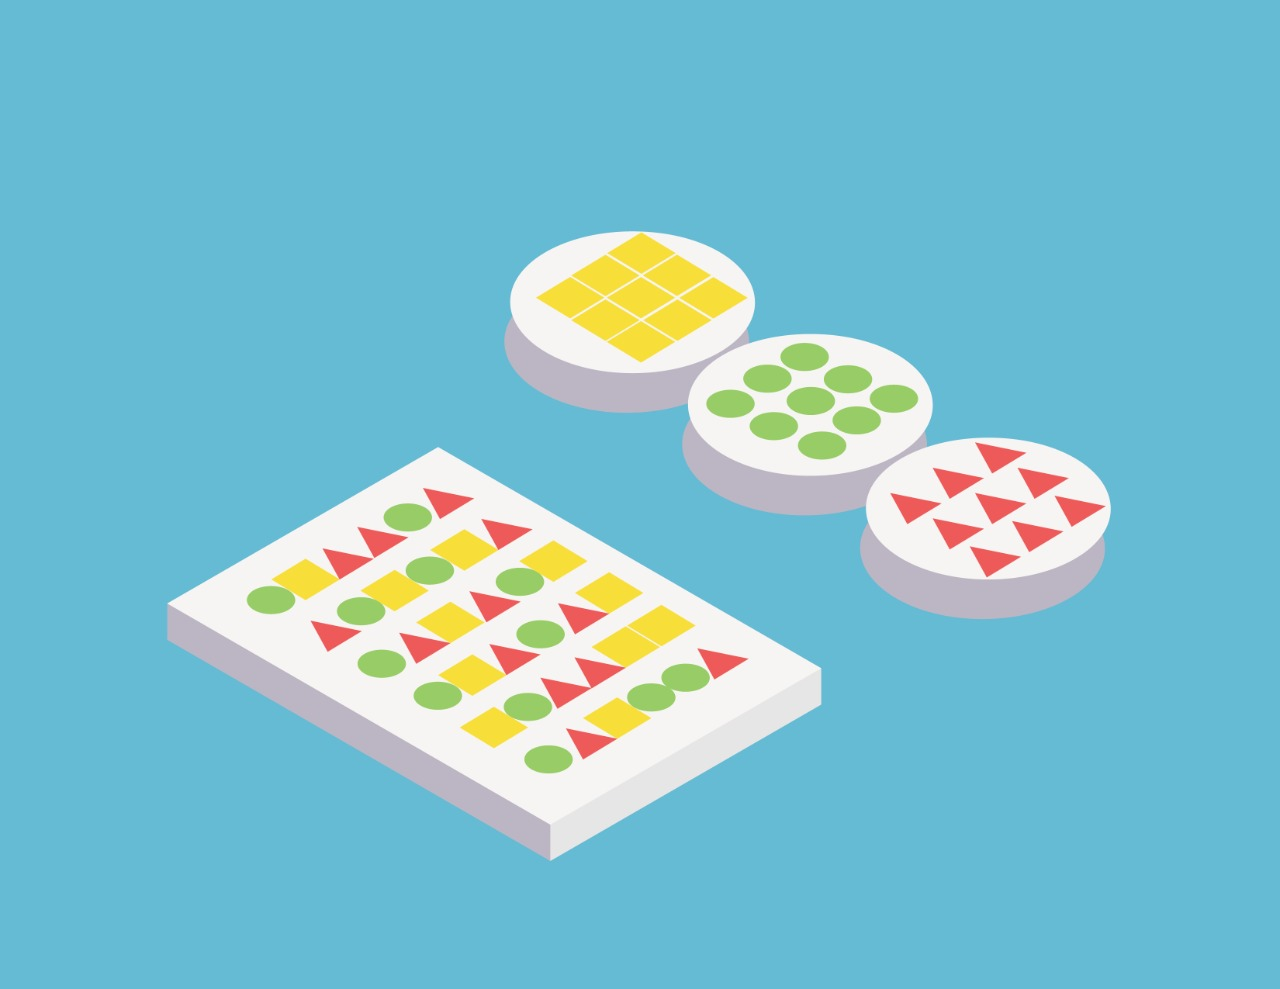

In [ ]:
Image('LDAg1.jpeg',width=500)



Que supone que cada tema está compuesto por una distribución de palabras y que cada documento es una distribución o mezcla de temas.\
De manera mas formal, el LDA genera cada documento $w$ en D de la siguiente manera:

1.   Supone N, el número de palabras tal que $N \sim Poisson(\zeta)$.
2.   Supone $\theta \sim Dir(\alpha)$ la distribución de los tópicos dentro del documento.
3.   Para cada una de las N palabras:\
      a. Elige un tema $z_n \sim $ Multinomial($\theta$)\
      b. Elige una palabra, $w_n$, via $p(w_n|z_n,\beta)$, una probabilidad multinomial condicionada al tema $z_n$\
De manera gráfica:

      ![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Latent_Dirichlet_allocation.svg/320px-Latent_Dirichlet_allocation.svg.png)
      

#### Estimación de parámetros

Entonces, en el LDA el objetivo es estimar:

\begin{align*}
p(\theta, z|w,\alpha,\beta) = \frac{p(\theta, z,w|\alpha,\beta)}{p(w|\alpha,\beta)}
\end{align*}

Es decir, la distribución a posteriori de las variables desconocidas. En otras palabras, se busca la distribución y número de tópicos en cada documento.

Sin embargo al hacer esta optimización se encuentran 2 problemas: 
> Esta distribución a posteriori es incalculable analiticamente

> No asigna probabilidades a palabras que no estén en el corpus, por ende, un documento nuevo con palabras similares pero distintas, obtendría probabilidad 0.

Para solucionar este problema se emplea, entre otros, la **inferencia variacional**. Un proceso que consiste básicamente en estimar esta distribución con base a otra "parecida" y esta medida de parecido se obtiene via **divergencia KL**. Es decir, estimar estas distribuciones se convierte en un problema de minimizar la divergencia KL

###Librerias Requeridas

**Instalación de paquetes**

Para este proyecto serán necesarios los paquetes de

>pandas

>numpy

>nltk

>gensim

Si no los hemos instalado ejecutamos los siguientes códigos

In [ ]:
pip install pandas

In [ ]:
pip install nltk

In [ ]:
pip install gensim

In [ ]:
pip install pyLDAvis

Una vez instalados los paquetes, importamos las siguientes librerias

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [ ]:
import numpy as np
import pandas as pd

from numpy import array

In [ ]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

Si no sabemos el lugar donde se aloja nuestro documento, y por lo tanto, donde debe alojarse nuestra base de datos, ejecutamos el siguiente código

In [ ]:
import os

In [ ]:
print(os.getcwd())

/content


###Base de datos

nuestra base de datos fue tomada de https://www.kaggle.com/hsrobo/titlebased-semantic-subject-indexing#pubmed.csv

En esta base encontramos el dominio de ecónomia y negocios **EconBiz** la cual contiene cerca de 1'069.000 títulos de sus libros y revistas.
Nuestro objetivo con ella es lograr clasificar los textos según su titulo.
Dado lo anterior, una vez la base de datos esté posicionada en el mismo lugar donde se aloja nuestro cuaderno basta con declarar la base como sigue

In [ ]:
datos=pd.read_csv('econbiz.csv', error_bad_lines=False)

organizamos y definimos la base de datos para una facilitar el manejo

In [ ]:
data=datos[['title']]
data['index']=data.index
documentos=data

Una breve previsualización del documento:

In [ ]:
print(len(documentos["title"]))
print(documentos[:5])

1064634
                                               title  index
0  Water insecurity and the poor : issues and res...      0
1  Crop biotechnology in developing countries : a...      1
2     Medicaid, intergovernmental trends and options      2
3  State solvency regulation of property-casualty...      3
4    Tax and expenditure limits on local governments      4


###Lematización y Stemming

El stemming es el metodo que usaremos para reducir las palabras a sus raices. Aunque existen diversos algoritmos, el más usual y usado para textos en inglés es el algoritmo de Martin Porter

In [ ]:
stemmer=PorterStemmer()

Una vez definido el algoritmo usado para el stemming descargaremos ahora **Wordnet** una popular base de datos del lexico inglés que nos brinda además un conjunto de sinónimos para las palabras.

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [ ]:
def preproceso(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            result.append(lemmatize_stemming(token))
    return result

 

Veamos que las funciones se están ejecutando como se desea con una muestra de los títulos 

In [ ]:
np.random.seed(8241)

In [ ]:
doc_sample=documentos[documentos['index']==1120].values[0][0]

In [ ]:
print('documento original: ')
words=[]
for word in doc_sample.split(' '):
    words.append(word)
print(words)

documento original: 
['The', 'structure', 'and', 'conduct', 'of', 'corporate', 'lobbying', ':', 'how', 'firms', 'lobby', 'the', 'federal', 'communications', 'commission']


In [ ]:
print('\n\n documento preprocesado: ')
print(preproceso(doc_sample))



 documento preprocesado: 
['structur', 'conduct', 'corpor', 'lobbi', 'firm', 'lobbi', 'feder', 'commun', 'commiss']


Efectivamente el código funciona. así que lo ejecutamos ahora para toda la base de datos, proceso que puede tomar unos minutos.

In [ ]:
doc_preprocesado = documentos['title'].map(preproceso)


In [ ]:
doc_preprocesado[:10]

0         [water, insecur, poor, issu, research, need]
1    [crop, biotechnolog, develop, countri, concept...
2                            [medicaid, trend, option]
3    [state, solvenc, regul, properti, casualti, li...
4                   [expenditur, limit, local, govern]
5    [ethic, dimens, technolog, watch, assess, proc...
6                        [paradox, fate, repres, firm]
7    [regulatori, reform, agenc, effort, elimin, re...
8    [differenti, regulatori, approach, futur, regu...
9    [student, financ, undergradu, educ, essay, stu...
Name: title, dtype: object

Creamos nuestro diccionario de palabras con los documentos procesados como sigue

In [ ]:
diccionario = gensim.corpora.Dictionary(doc_preprocesado)
count=0
for k, v in diccionario.iteritems():
    print(k,v)
    count += 1
    if count>10:
        break

0 insecur
1 issu
2 need
3 poor
4 research
5 water
6 analys
7 ant
8 biotechnolog
9 conceptu
10 countri


Creamos un filtro para las palabras en nuestro diccionario que nos deje las palabras que aparecen en menos de 15 documentos o en más de 0.5 y de estos mantendremos los 100000 más frecuentes (Tokens)

In [ ]:
diccionario.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
Bolsa_palabras=[diccionario.doc2bow(doc) for doc in doc_preprocesado]
Bolsa_palabras[1120]

[(19, 1), (46, 1), (92, 1), (519, 1), (539, 1), (665, 1), (1283, 1), (1507, 2)]

In [ ]:
Bolsa_1120= Bolsa_palabras[1120]

In [ ]:
for i in range(len(Bolsa_1120)):
    print("Word {} (\"{}\") appears {} time.".format(Bolsa_1120[i][0], 
                                               diccionario[Bolsa_1120[i][0]], 
Bolsa_1120[i][1]))

Word 19 ("commiss") appears 1 time.
Word 46 ("firm") appears 1 time.
Word 92 ("structur") appears 1 time.
Word 519 ("commun") appears 1 time.
Word 539 ("corpor") appears 1 time.
Word 665 ("feder") appears 1 time.
Word 1283 ("conduct") appears 1 time.
Word 1507 ("lobbi") appears 2 time.


In [ ]:
from gensim import corpora, models

Del paquete anterior utilizaremos el modelo Term Frequency - Inverse Document Frequency (TFIDF) 

En este modelo nos interesa ponderar la importancia de una palabra en una colección de documentos.

Para esto, como es lógico pensar, nos interesa saber la frecuencia de una palabra en una coleccion pero ademas su frecuencia inversa del documento lo que nos permitirá saber si el término evaluado es o no común.

Para esto se denomina 

\begin{align*}
W_{i,j}&=tf_{i,j}*idf_{i,N}\\
       &=f(i,j)*log\left(\frac{N}{df_i}\right)
\end{align*}
Donde $f(i,j)$ es la frecuencia de $i$ en $j$, $N$ es el Número total de documentos en la colección y $df_i$ es el número de documentos que contienen a $i$ 

In [ ]:
tfidf = models.TfidfModel(Bolsa_palabras)
corpus_tfidf = tfidf[Bolsa_palabras]

Podemos ver los puntajes para nuestro primer documento cómo sigue

In [ ]:
from pprint import pprint

In [ ]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5610912147181364),
 (1, 0.292224737306286),
 (2, 0.4058239423632345),
 (3, 0.4220418885139717),
 (4, 0.3053305810603665),
 (5, 0.4046506642600007)]


##Coherencia

Existen varias medidas para evaluar los modelos de clasificación de textos. Entre ellas se encuentran, la perplejidad y la coherencia. 

Por un lado, la perplejidad es una medida de evaluación intrinseca y representa que tanta sorpresa tiene un modelo sobre datos que no había visto antes.
Sin embargo, optimizar el modelo según su valor de perplejidad puede llevar a definir topicos que no pueden ser interpretables por personas.

Así pues, por otro lado se tiene la cohorencia definida como la medida del parecido semantico entre las principales palabras de un tópico. 
Existen varias medidas de coherencia:

*   **C_v=** Es una medida que considera la probabilidad de que una palabra o grupo de palabras aparezcan dado que otras palabras (o grupos de palabras) están presentes. 
*   **Umass=** Es una medida intrinseca que considera unicámente las palabras contiguas, es decir, compara una palabra unicamente con la palabra anterior y la palabra siguiente. 



Ahora, se quiere definir el número de temas en los que serán clasificados los textos. Para esto, se empleará el valor **Cv**.:


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

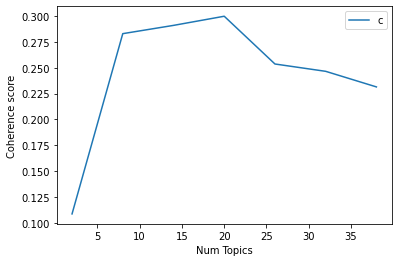

In [ ]:
# Grafica sin economy
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=diccionario, corpus=Bolsa_palabras, texts=doc_preprocesado, start=2, limit=40, step=6)

In [ ]:
#tardó aproximadamente 35 minutos

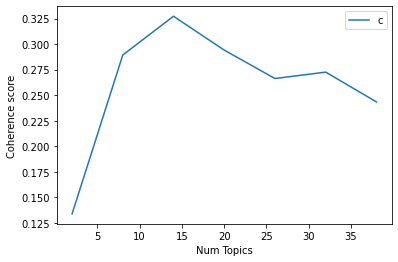

In [ ]:
# modelo usual
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

El grafíco muestra un valor calculado de coherencia que crece hasta 14, por tanto, este número de temas será el utilizado.

In [ ]:
def compute_coherence_values3(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,passes=2, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values3(dictionary=diccionario, corpus=corpus_tfidf, texts=doc_preprocesado, start=2, limit=40, step=6)

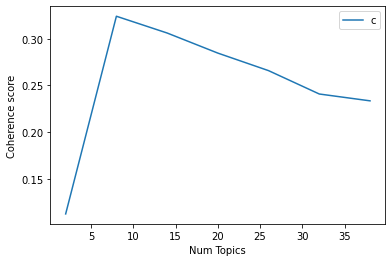

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1127
Num Topics = 8  has Coherence Value of 0.324
Num Topics = 14  has Coherence Value of 0.3061
Num Topics = 20  has Coherence Value of 0.2846
Num Topics = 26  has Coherence Value of 0.2658
Num Topics = 32  has Coherence Value of 0.2409
Num Topics = 38  has Coherence Value of 0.2336


##Ejecutando el LDA

In [ ]:
np.random.seed(822)

In [ ]:
lda_model=gensim.models.LdaMulticore(Bolsa_palabras, num_topics=14, id2word=diccionario, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))

Topic: 0 Words: 0.034*"health" + 0.027*"effect" + 0.021*"famili" + 0.018*"insur" + 0.017*"employe" + 0.017*"life" + 0.016*"women" + 0.016*"work" + 0.016*"self" + 0.016*"program"
Topic: 1 Words: 0.096*"trade" + 0.089*"intern" + 0.025*"cross" + 0.024*"data" + 0.020*"export" + 0.018*"america" + 0.017*"analysi" + 0.017*"evid" + 0.017*"american" + 0.016*"team"
Topic: 2 Words: 0.091*"manag" + 0.050*"busi" + 0.031*"invest" + 0.029*"research" + 0.027*"practic" + 0.019*"strateg" + 0.019*"resourc" + 0.016*"project" + 0.016*"leadership" + 0.015*"strategi"
Topic: 3 Words: 0.076*"capit" + 0.032*"measur" + 0.030*"power" + 0.029*"custom" + 0.028*"econom" + 0.026*"theori" + 0.023*"growth" + 0.023*"understand" + 0.021*"influenc" + 0.021*"mobil"
Topic: 4 Words: 0.067*"state" + 0.049*"report" + 0.045*"govern" + 0.034*"nation" + 0.033*"energi" + 0.029*"unit" + 0.025*"financ" + 0.021*"local" + 0.018*"hous" + 0.017*"execut"
Topic: 5 Words: 0.046*"time" + 0.036*"work" + 0.033*"valu" + 0.032*"environment" + 0

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=14, id2word=diccionario, passes=2, workers=4)

In [ ]:
 for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.014*"ethic" + 0.012*"educ" + 0.011*"firm" + 0.010*"perform" + 0.010*"corpor" + 0.009*"multin" + 0.008*"industri" + 0.008*"manufactur" + 0.008*"school" + 0.007*"busi"
Topic: 1 Word: 0.017*"research" + 0.017*"manag" + 0.012*"journal" + 0.012*"health" + 0.011*"busi" + 0.011*"handbook" + 0.011*"review" + 0.010*"project" + 0.009*"small" + 0.008*"care"
Topic: 2 Word: 0.023*"innov" + 0.019*"knowledg" + 0.015*"manag" + 0.014*"technolog" + 0.011*"network" + 0.010*"organ" + 0.009*"develop" + 0.009*"servic" + 0.008*"busi" + 0.008*"report"
Topic: 3 Word: 0.022*"brand" + 0.015*"direct" + 0.014*"invest" + 0.013*"tourism" + 0.013*"leadership" + 0.013*"foreign" + 0.013*"custom" + 0.011*"retail" + 0.010*"creation" + 0.009*"advertis"
Topic: 4 Word: 0.020*"model" + 0.012*"estim" + 0.010*"time" + 0.009*"data" + 0.009*"approach" + 0.008*"analysi" + 0.008*"test" + 0.008*"forecast" + 0.007*"applic" + 0.007*"method"
Topic: 5 Word: 0.023*"develop" + 0.019*"econom" + 0.015*"sustain" + 0.014*"es

In [ ]:
for index, score in sorted(lda_model[Bolsa_palabras[1120]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[Bolsa_palabras[1120]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

## Representación grafica de los temas


In [ ]:
import IPython
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,Bolsa_palabras,diccionario,sort_topics=False)

In [ ]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.141044  0.116485       1        1  6.095220
1     -0.044697  0.123451       2        1  6.103898
2     -0.006459 -0.239752       3        1  8.520521
3     -0.010700 -0.101854       4        1  5.285633
4      0.271744  0.080386       5        1  6.453299
5     -0.153542  0.088867       6        1  5.516302
6      0.167365 -0.019641       7        1  9.485441
7     -0.063575 -0.104163       8        1  8.402887
8     -0.108102  0.041384       9        1  5.734790
9      0.234119 -0.028499      10        1  7.885127
10    -0.105007  0.238554      11        1  6.230328
11    -0.152199 -0.240565      12        1  9.691044
12    -0.070902  0.003711      13        1  7.687577
13     0.182999  0.041635      14        1  6.907928, topic_info=         Term          Freq         Total Category  logprob  loglift
196    polici  57574.000000  57574.000000  Default  30.0000  30.0000
12    develop  68168.000000  68168.000000  Default  29.0000  29.0000
642     manag  53405.000000  53405.000000  Default  28.0000  28.0000
175     model  51254.000000  51254.000000  Default  27.0000  27.0000
172     trade  40425.000000  40425.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
130    market  12972.638672  90339.007812  Topic14  -3.6013   0.7318
37     integr   4595.775879  19211.619141  Topic14  -4.6391   1.2421
97   european   4028.981934  19319.458984  Topic14  -4.7707   1.1049
178      case   4101.264160  35016.007812  Topic14  -4.7529   0.5280
213      role   4026.462646  27449.273438  Topic14  -4.7713   0.7530

[664 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
760       4  0.999668    academ
2953      7  0.999394   acceler
526       3  0.198218   account
526       5  0.002076   account
526      10  0.222373   account
...     ...       ...       ...
491       1  0.999638  workplac
244       2  0.172517     world
244      10  0.827395     world
589       5  0.957110      year
589       7  0.042791      year

[1018 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [ ]:
import IPython
pyLDAvis.save_html(vis, 'index.html')

De no ser posible la vizualización dirigirse a https://afve48.github.io/AFVE48.gitub.io/

##Deducción sobre los temas

In [ ]:
Topic=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
Meanning=['Life quality','Commerce & Company trade','Business management','Economic theory','State economy','Work environment','International policy','Industry & Innovation','Market transformation','Global economics','Development & Sustain','Risk and data analysis','Foreign Exchange','Banking & Financial system']
Lista_topicos=pd.DataFrame({"Topic": Topic,"Meanning":Meanning})

In [ ]:
Lista_topicos.set_index('Topic', inplace=True) 
print(Lista_topicos)

                         Meanning
Topic                            
1                    Life quality
2        Commerce & Company trade
3             Business management
4                 Economic theory
5                   State economy
6                Work environment
7            International policy
8           Industry & Innovation
9           Market transformation
10               Global economics
11          Development & Sustain
12         Risk and data analysis
13               Foreign Exchange
14     Banking & Financial system


In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

##Prueba en nuevo elemento

In [ ]:
Nuevo_doc = 'Markets for risk and openness to trade: how are they related?'

In [ ]:
bow_vector = diccionario.doc2bow(preproceso(Nuevo_doc))

In [ ]:
b=pd.DataFrame(list(zip(lda_model[bow_vector],Meanning)),columns=["score","topic"])
print(b)

                score                       topic
0    (0, 0.011905088)                Life quality
1     (1, 0.30684856)    Commerce & Company trade
2    (2, 0.011905067)         Business management
3    (3, 0.011905067)             Economic theory
4    (4, 0.011905089)               State economy
5    (5, 0.011905128)            Work environment
6    (6, 0.011905067)        International policy
7    (7, 0.011905099)       Industry & Innovation
8    (8, 0.011905096)       Market transformation
9     (9, 0.26194552)            Global economics
10  (10, 0.011905104)       Development & Sustain
11   (11, 0.17975433)      Risk and data analysis
12   (12, 0.13240062)            Foreign Exchange
13  (13, 0.011905141)  Banking & Financial system


In [ ]:
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.30695658922195435	 Topic: 0.096*"trade" + 0.089*"intern" + 0.025*"cross" + 0.024*"data" + 0.020*"export"
Score: 0.26118791103363037	 Topic: 0.071*"social" + 0.060*"global" + 0.054*"economi" + 0.043*"corpor" + 0.032*"crisi"
Score: 0.17974290251731873	 Topic: 0.077*"model" + 0.047*"risk" + 0.027*"consum" + 0.020*"approach" + 0.019*"applic"
Score: 0.13306163251399994	 Topic: 0.098*"market" + 0.036*"price" + 0.023*"evid" + 0.023*"financi" + 0.023*"exchang"
Score: 0.011905143968760967	 Topic: 0.064*"bank" + 0.042*"competit" + 0.042*"region" + 0.040*"public" + 0.034*"sector"
Score: 0.011905129067599773	 Topic: 0.046*"time" + 0.036*"work" + 0.033*"valu" + 0.032*"environment" + 0.025*"survey"
Score: 0.011905104853212833	 Topic: 0.037*"suppli" + 0.034*"educ" + 0.029*"incom" + 0.029*"labor" + 0.024*"inequ"
Score: 0.01190510019659996	 Topic: 0.056*"innov" + 0.051*"product" + 0.051*"industri" + 0.049*"firm" + 0.030*"technolog"
Score: 0.011905096471309662	 Topic: 0.084*"chang" + 0.043*"cos

In [ ]:
for index, score in sorted(lda_model[bow_vector],key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score,b['topic'][index]))

Score: 0.306924045085907	 Topic: Commerce & Company trade
Score: 0.26166635751724243	 Topic: Global economics
Score: 0.17975133657455444	 Topic: Risk and data analysis
Score: 0.13260731101036072	 Topic: Foreign Exchange
Score: 0.011905142106115818	 Topic: Banking & Financial system
Score: 0.011905129067599773	 Topic: Work environment
Score: 0.011905104853212833	 Topic: Development & Sustain
Score: 0.01190510019659996	 Topic: Industry & Innovation
Score: 0.011905096471309662	 Topic: Market transformation
Score: 0.01190508995205164	 Topic: State economy
Score: 0.011905089020729065	 Topic: Life quality
Score: 0.011905067600309849	 Topic: Business management
Score: 0.011905067600309849	 Topic: Economic theory
Score: 0.011905067600309849	 Topic: International policy


##Mallet

Otro método para hacer el LDA, es el algoritmo Mallet (**MA**chine **L**earning for **L**enguag**E T**oolkit) un algoritmo que emplea un metodo de estimación distinto al de Gensim, ya que hace uso del muestreador de Gibbs en vez de la inferencia variacional que usa este último.

Ya que el LDAMallet está implementado en JAVA debe ser cargado previamente, lo que se hace a continuación. 

In [ ]:
from gensim.models.wrappers import LdaMallet

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [ ]:
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version

In [ ]:
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-06-19 00:32:43--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.8MB/s    in 0.9s    

2020-06-19 00:32:44 (17.8 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip

In [ ]:
import zipfile
from google.colab import files

In [ ]:
uploaded = files.upload()

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

Así pues, luego de cargarlo, se calcula la coherencia para el modelo Mallet

In [ ]:
def compute_coherence_values2(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Duración aprox 2h15min

In [ ]:
model_list, coherence_values = compute_coherence_values2(dictionary=diccionario, corpus=Bolsa_palabras, texts=doc_preprocesado, start=2, limit=40, step=6)

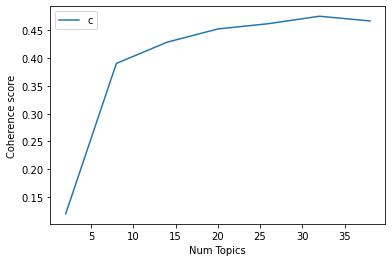

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1196
Num Topics = 8  has Coherence Value of 0.3905
Num Topics = 14  has Coherence Value of 0.4286
Num Topics = 20  has Coherence Value of 0.4524
Num Topics = 26  has Coherence Value of 0.4619
Num Topics = 32  has Coherence Value of 0.4753
Num Topics = 38  has Coherence Value of 0.4668


Entonces, se ve que el LDAMallet presenta mejor coherencia respecto al LDA calculado por Gensim

In [ ]:
np.random.seed(821)

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=Bolsa_palabras, num_topics=15, id2word=diccionario)

In [ ]:
for idx, topic in ldamallet.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))

Topic: 0 Words: 0.037*"incom" + 0.037*"employ" + 0.034*"work" + 0.033*"labour" + 0.030*"labor" + 0.023*"welfar" + 0.023*"effect" + 0.020*"wage" + 0.019*"distribut" + 0.019*"unemploy"
Topic: 1 Words: 0.046*"effect" + 0.042*"servic" + 0.034*"role" + 0.029*"health" + 0.025*"decis" + 0.024*"consum" + 0.023*"relationship" + 0.022*"behavior" + 0.021*"qualiti" + 0.016*"make"
Topic: 2 Words: 0.094*"economi" + 0.054*"global" + 0.045*"polit" + 0.043*"busi" + 0.037*"world" + 0.033*"perspect" + 0.027*"transit" + 0.025*"small" + 0.024*"challeng" + 0.022*"enterpris"
Topic: 3 Words: 0.102*"trade" + 0.056*"invest" + 0.050*"region" + 0.042*"countri" + 0.040*"intern" + 0.038*"foreign" + 0.028*"integr" + 0.028*"polici" + 0.025*"implic" + 0.024*"africa"
Topic: 4 Words: 0.099*"industri" + 0.056*"public" + 0.044*"govern" + 0.044*"sector" + 0.040*"chang" + 0.036*"structur" + 0.029*"privat" + 0.025*"environment" + 0.023*"competit" + 0.021*"regul"
Topic: 5 Words: 0.092*"manag" + 0.043*"corpor" + 0.031*"strateg

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

Pretty printing has been turned ON


In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=doc_preprocesado, dictionary=diccionario, coherence='c_v')

In [ ]:
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

In [ ]:
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.44542008815449


##Clasificación de archivos vistos

Ahora, calculando el tema más representativo de cada documento (En este caso se muestran solo los primeros 1000 elementos)

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=Bolsa_palabras, texts=documentos['title']):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus[:1000]]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=Bolsa_palabras, texts=documentos['title'])

In [ ]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
df_dominant_topic.head(1000)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.3825,"suppli, educ, labor, market, evid, differ, dis...",Water insecurity and the poor : issues and res...
1,1,6.0,0.3490,"develop, polici, econom, china, sustain, count...",Crop biotechnology in developing countries : a...
2,2,10.0,0.2679,"suppli, educ, labor, market, evid, differ, dis...","Medicaid, intergovernmental trends and options"
3,3,0.0,0.3700,"health, effect, famili, insur, qualiti, life, ...",State solvency regulation of property-casualty...
4,4,4.0,0.8143,"state, report, govern, nation, energi, financ,...",Tax and expenditure limits on local governments
...,...,...,...,...,...
995,995,9.0,0.5091,"social, global, economi, corpor, crisi, polit,...",Dropout and enrollment trends in the post-war ...
996,996,10.0,0.7679,"suppli, educ, labor, market, evid, differ, dis...",Why do the poor live in cities?
997,997,10.0,0.6143,"suppli, educ, labor, market, evid, differ, dis...",Employment patterns in OECD countries
998,998,11.0,0.5178,"model, risk, consum, price, applic, approach, ...",Local instrumental variables


##Encontrar el documento más representativo para cada tópico

Así mismo, se buscan los documentos más representativos de cada uno de los 14 tópicos

In [ ]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [ ]:
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

In [ ]:
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [ ]:
sent_topics_sorteddf.head(14)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8839,"health, effect, famili, insur, qualiti, life, ...",The retirement behavior of married couples : e...
1,1.0,0.7808,"trade, intern, cross, data, export, america, a...",C & C - contraction and convergence of carbon ...
2,2.0,0.7678,"manag, busi, invest, research, practic, strate...",Assessing affirmative action
3,3.0,0.8452,"capit, growth, measur, econom, custom, power, ...",Human capital creates insider power
4,4.0,0.8622,"state, report, govern, nation, energi, financ,...",Outlook for the state of the US economy in 199...
5,5.0,0.6905,"time, work, valu, environment, long, survey, t...",The determinants of trust
6,6.0,0.8452,"develop, polici, econom, china, sustain, count...",Designing stabilization policy in a monetary u...
7,7.0,0.8143,"innov, industri, product, firm, technolog, net...",FDI and the dynamics of productivity : microec...
8,8.0,0.7107,"chang, cost, effici, employ, climat, worker, p...",Comparing hospital quality at for-profit and n...
9,9.0,0.8143,"social, global, economi, corpor, crisi, polit,...",Economic analysis of social interactions
